# Курс "Методы современной прикладной статистики"
# 3 курс ФПМИ МФТИ, весна 2022
## Домашнее задание 3. Критерии согласия, проверка нормальности, бутстреп

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as spss
import seaborn as sns
import pandas as pd
sns.set(style='darkgrid', font_scale=1.4)
%matplotlib inline
%config InlineBackend.figure_format="retina"  # only for retina display

import warnings
warnings.filterwarnings('ignore')

### Условие

### Задача 1

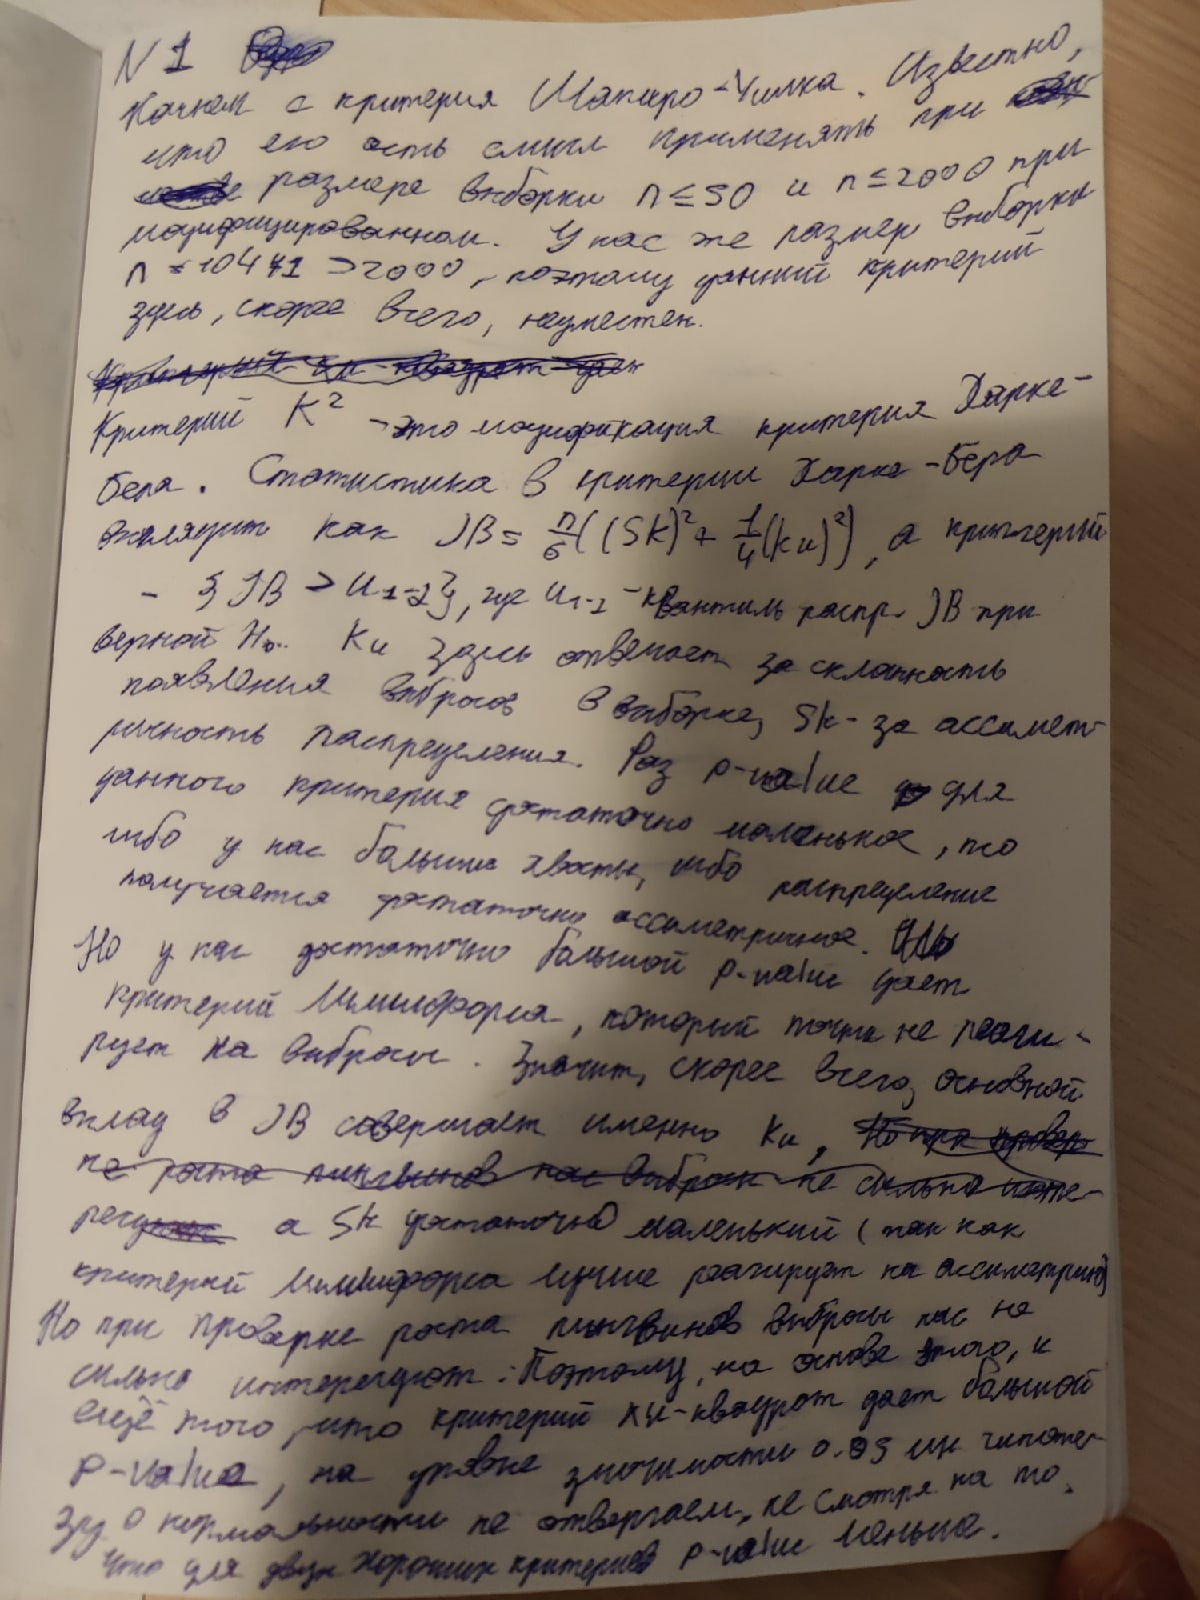

### Задача 2

Зафиксируем уровень значимости $\alpha = 0.05$. Считаем данные и посмотрим на гистограмму.

In [2]:
data = pd.read_csv("slump_test.data")
vals = data["Compressive Strength (28-day)(Mpa)"]
vals

0      34.99
1      41.14
2      41.81
3      42.08
4      26.82
       ...  
98     49.97
99     50.23
100    50.50
101    49.17
102    48.77
Name: Compressive Strength (28-day)(Mpa), Length: 103, dtype: float64

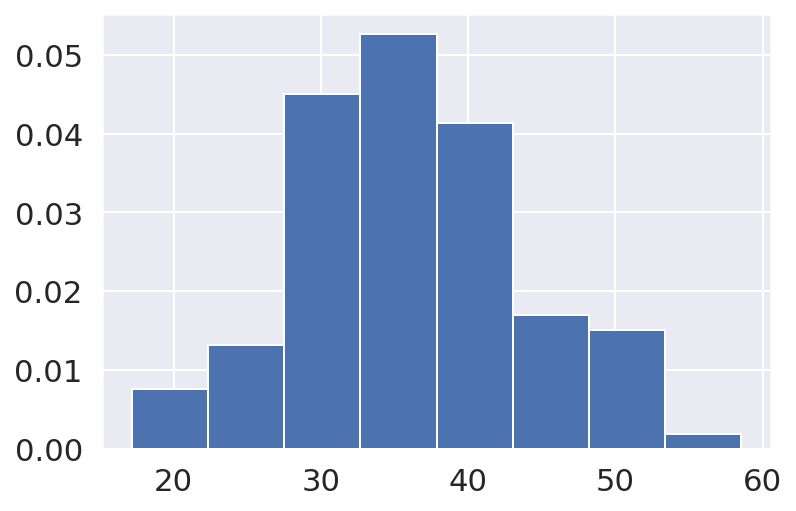

In [3]:
plt.hist(vals, bins = 8, density = True)
plt.show()

Распределение чем-то напоминает нормальное. Посмотрим на qq-plot

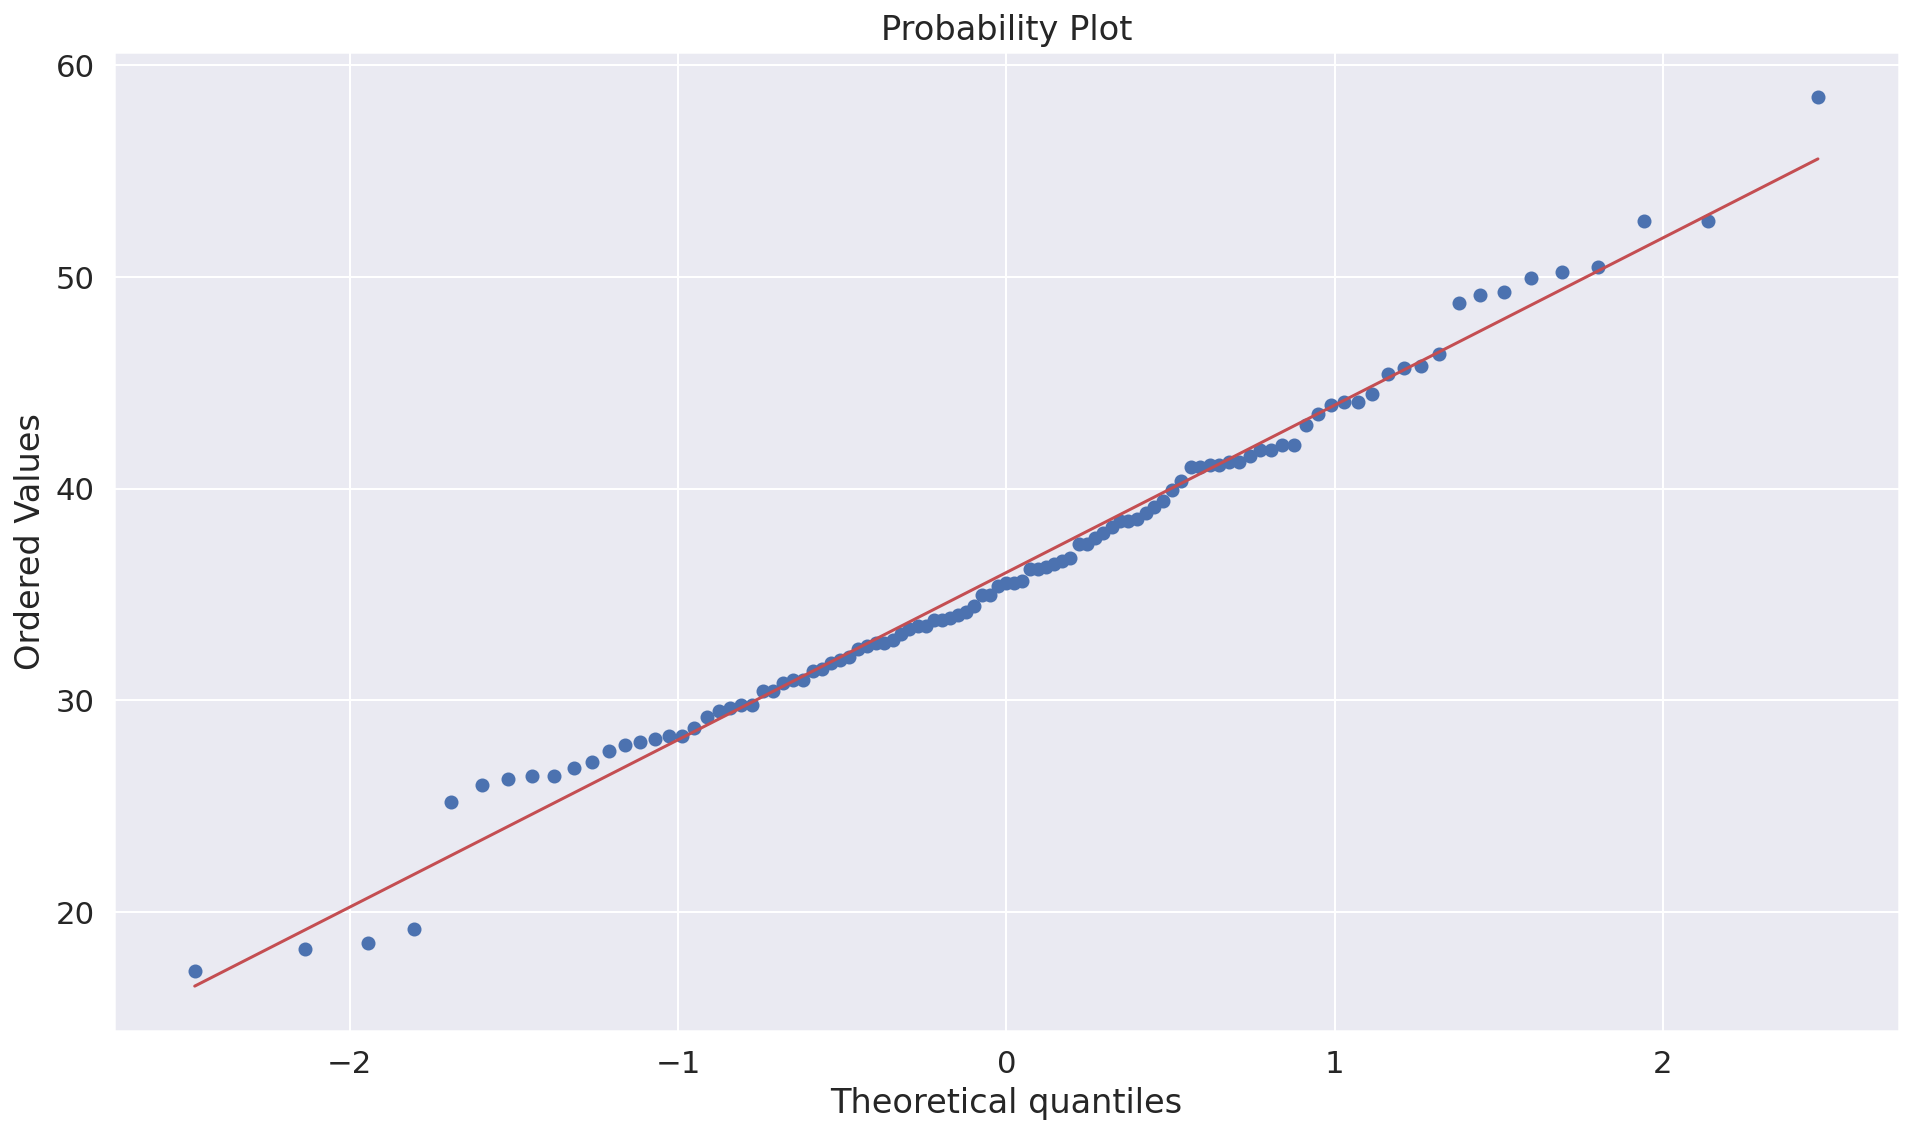

In [4]:
plt.figure(figsize = (16, 9))
sps.probplot(vals, plot=plt)
plt.show()

График хорошо ложится на прямую! поэтому будем искать распределение среди нормальных. Делать это будем как в критерии Лиллифорса -- найдем ОМП оценку параметров (выборочное среднее и дисперсия) и затем подставим в критерий Колмогорова-Смирнова.

In [5]:
a, sigma = vals.mean(), vals.var()
print(a, sigma)

36.03941747572816 61.4378780887112


In [6]:
sps.kstest(vals, sps.norm(a, np.sqrt(sigma)).cdf)

KstestResult(statistic=0.052032512342796745, pvalue=0.9293316546677821)

pvalue оказался  больше уровня значимости $\alpha$, а значит не отвергаем гипотезу о том, что данные имеют распределение $N(36.04, 61.44)$. 

### Задача 3

#### Первая выборка

Снова зафиксируем уровень значимости $\alpha = 0.01$, считаем данные и построим диаграмму.

In [7]:
sample = pd.read_csv("go_track_tracks.csv")["distance"]
sample = sorted(sample)

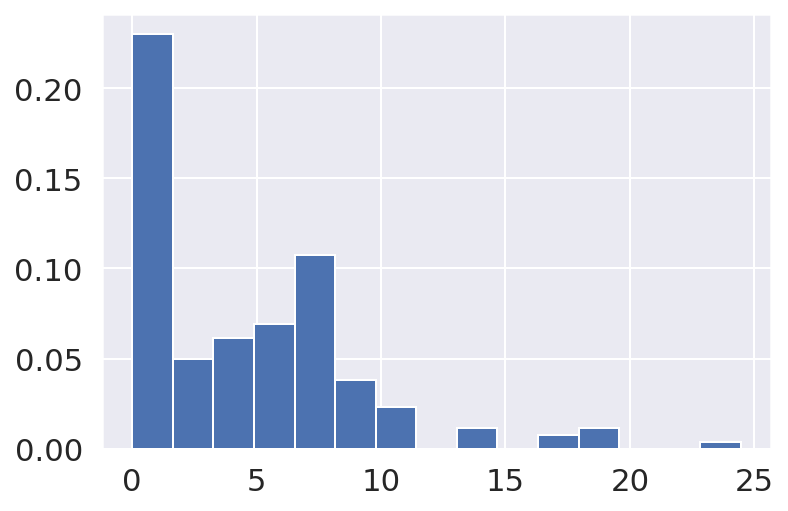

In [8]:
plt.hist(sample[:160], bins = 15, density = True)
plt.show()

Что мы видим -- большая часть данных расположена рядом с нулем, что наталкивает нас на экспоненциальное распредление. Однако в выборке присутсвуют выбросы и, как можно заметить, в промежутке с 3 до 12 вероятность распределена скорее как нормальное распределение. Поэтому, экспоненциальное распределние не подойдет. Чтобы еще раз в этом убедиться, посмотрим на qq-plot, который для экспоненциального распределния имеет смысл.  

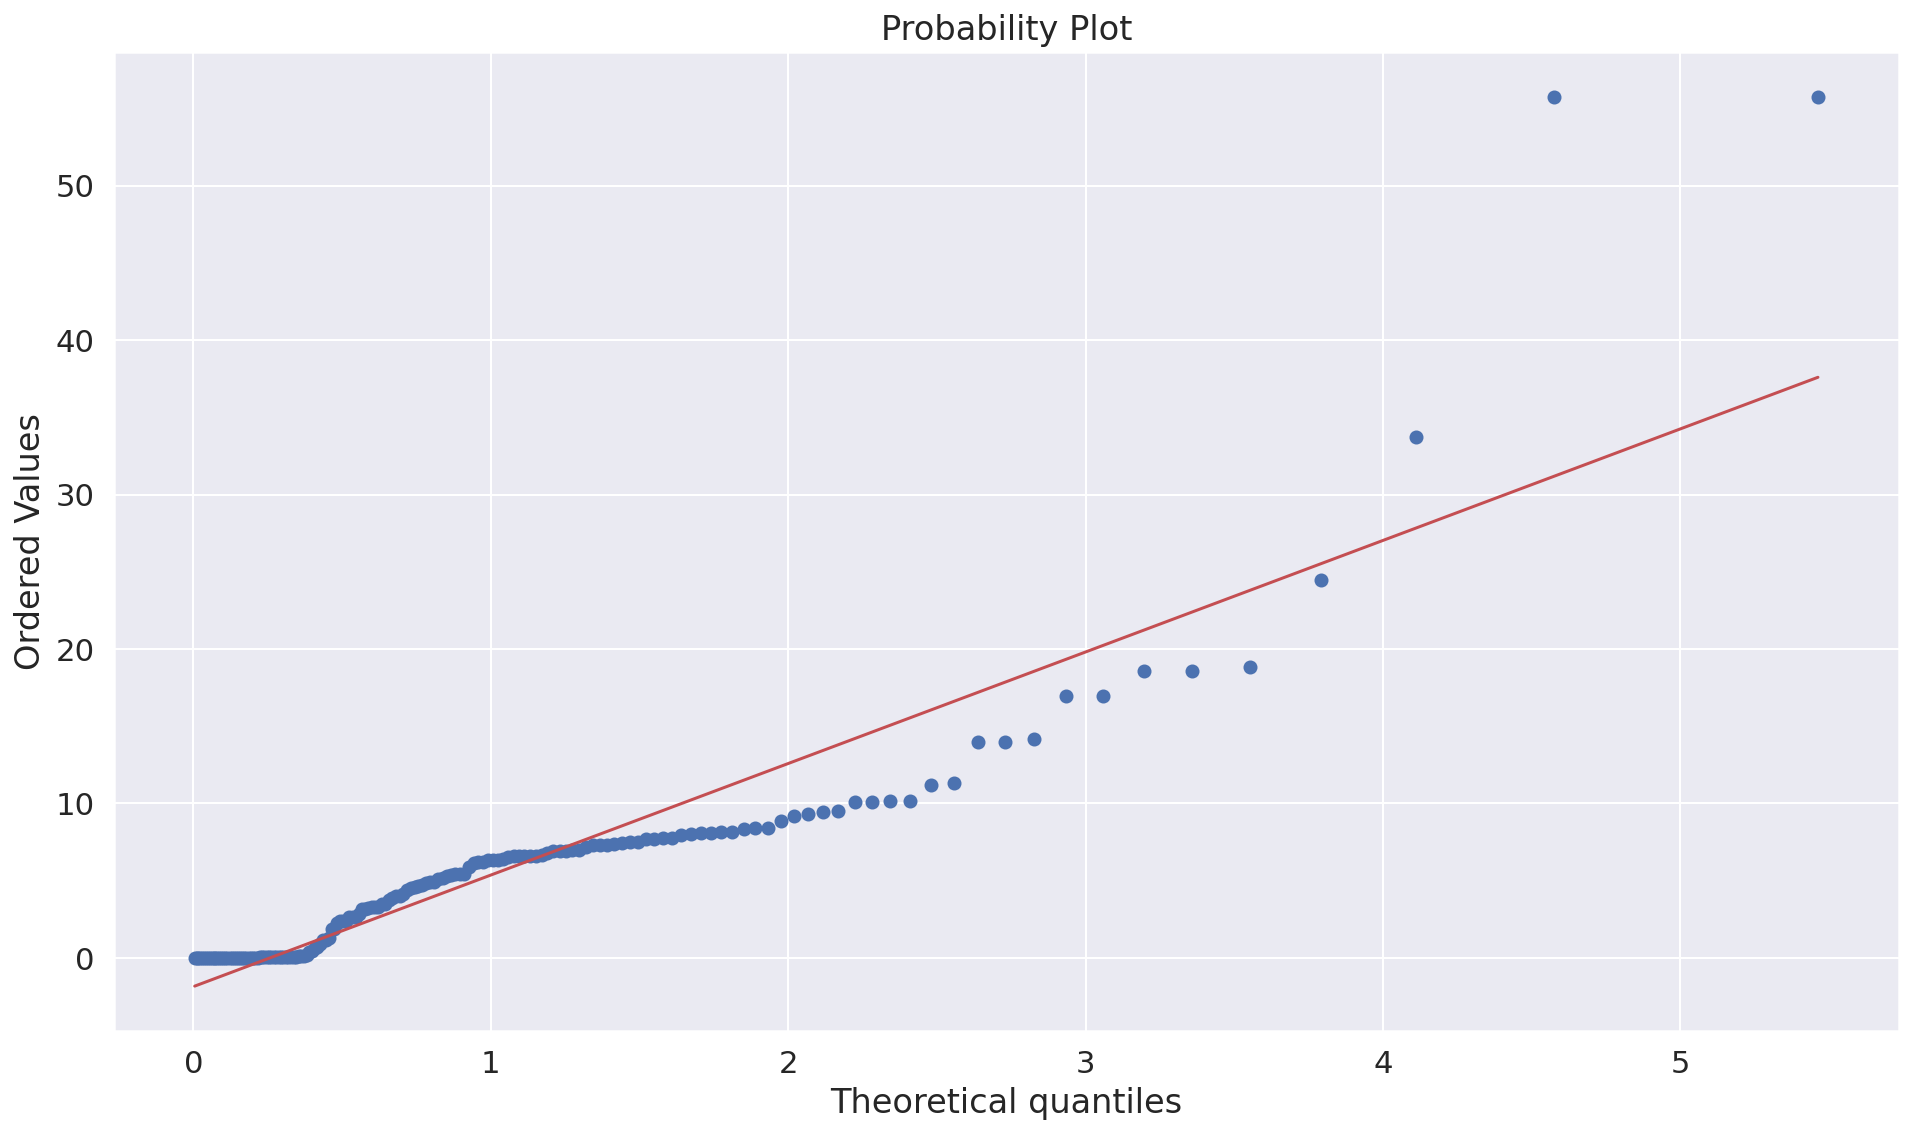

In [9]:
plt.figure(figsize = (16, 9))
sps.probplot(sample, plot=plt, dist = sps.expon)
plt.show()

Как мы видим, график плохо лежит на прямой, а значит гипотезу о том, что данные имеют эспоненциальное распределение можно смело отвегрнуть.

Рассмотрим оставшиеся непрерывные распределения  из первой лекции. Нормальное и модуль нормального распределения не подойдут, так как хвосты достаточно большие. Модуль распределения Коши может подойти лучше, его мы проверим. Бета-распределение имеет носитель от  0 до 1, поэтому тоже не будем его рассматривать. Также бесмысленно рассматривать равномерное распределение. Распределение парето не подойдет по тем же причинам,  что и экспоненциальное распределение.

Начнем с гамма распределения. Для данного распределения есть оценка по методу моментов, попробуем воспользоваться ей и подставить в критерий колмогорова нулевую гипотезу с этими параметрами.

In [10]:
def calc_gamma_moments(sample):
    return np.power(sample.mean(), 2) / sample.var(), sample.var() / sample.mean()

In [11]:
a, b = calc_gamma_moments(np.array(sample))
k_test = sps.kstest(sample, sps.gamma(a = b, scale = a).cdf)
k_test

KstestResult(statistic=0.3976500214309114, pvalue=9.22428040205331e-24)

Гипотеза, как и ожидалось, отвергается

Стандартные распределения ,как и ожидалось, провалились, осталось придумывать что-то новое. Например, если посмотреть на гамма-распределение, можно понять, что можно попробовать взять сумму экспоненциального и гамма-распределения.

Пример:

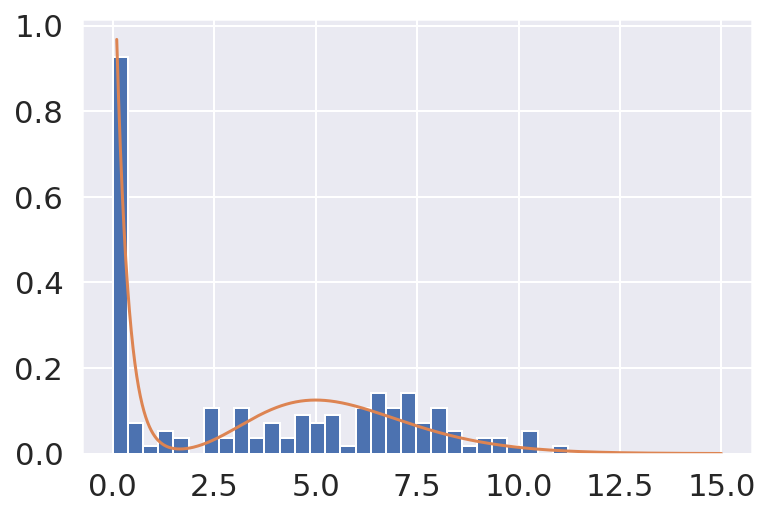

In [12]:
eps, exp, a, b  = 0.6, 3.4, 1.4, 8
f = lambda x: (1 - eps) * sps.expon(scale = 1 / exp).pdf(x) + eps * sps.gamma(a = b, scale = 1 /  a).pdf(x)
data = f(np.linspace(0.1 , 15, 1000))
plt.hist(sample[:150], bins = 30, density = True)
plt.plot(np.linspace(0.1 , 15, 1000),data)

In [13]:
k_test = sps.kstest(sample, lambda x: (1 - eps) * sps.expon(scale = 1 / exp).cdf(x) + eps * sps.gamma(a = b, scale = 1 /  a).cdf(x))
k_test

KstestResult(statistic=0.22897956377525525, pvalue=5.393158825799789e-08)

Попробуем найти оптимизатором лучшие параметры

In [14]:
from scipy.optimize import minimize, fmin
from scipy.optimize import Bounds

In [15]:
def calc_params(data):
    def func_to_minimize(x):
        return -np.sum(np.log(x[0] * sps.gamma(a = x[2], scale = 1 / x[1]).pdf(data) + (1 - x[0]) * sps.expon(scale = 1 / x[3]).pdf(data)))
    
    min_k = minimize(func_to_minimize, [0.6, 1.4, 2, 3.4],
                     bounds = Bounds ([0, 0, 0, 0], [1.0, 10000, 10000, 15000]), method='Nelder-Mead')   
    return min_k.x

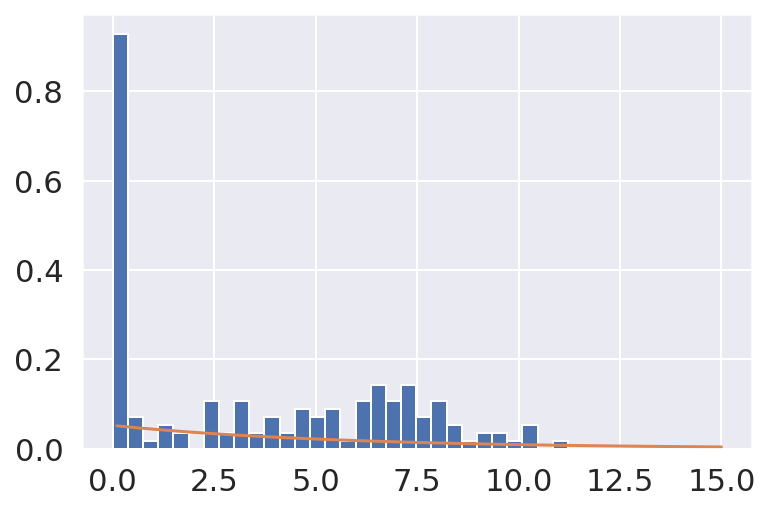

In [16]:
eps, exp, a, b  = calc_params(sample)
f = lambda x: (1 - eps) * sps.expon(scale = 1 / exp).pdf(x) + eps * sps.gamma(a = b, scale = 1 /  a).pdf(x)
data = f(np.linspace(0.1 , 15, 1000))
plt.hist(sample[:150], bins = 30, density = True)
plt.plot(np.linspace(0.1 , 15, 1000),data)

Как мы видим, ничего хорошего не вышло(

#### Вторая выборка

Снова зафиксируем уровень значимости $\alpha = 0.01$, считаем данные и построим диаграмму.

In [17]:
al = 0.05
data = pd.read_csv("abalone.data")
sample = data.iloc[: , 7]
sample = np.append(sample, float(data.columns[7]))

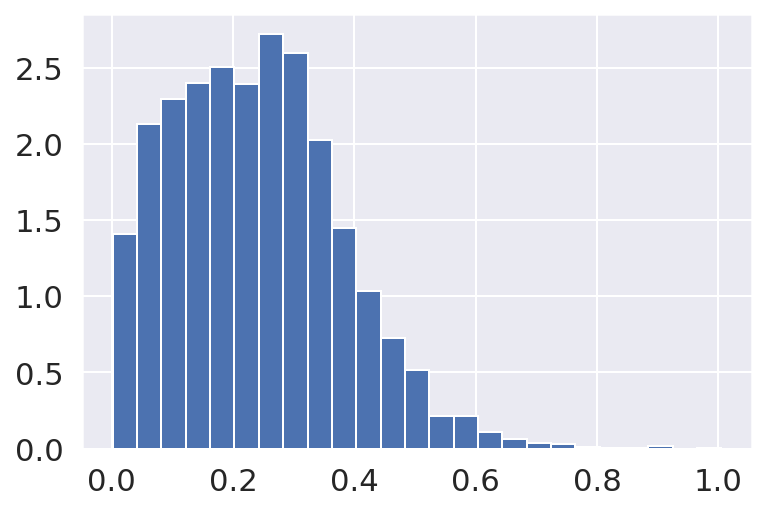

In [18]:
plt.hist(sample,bins = 25 ,density = True)
plt.show()

Попробуем проверить гипотезу о нормальности распределения:

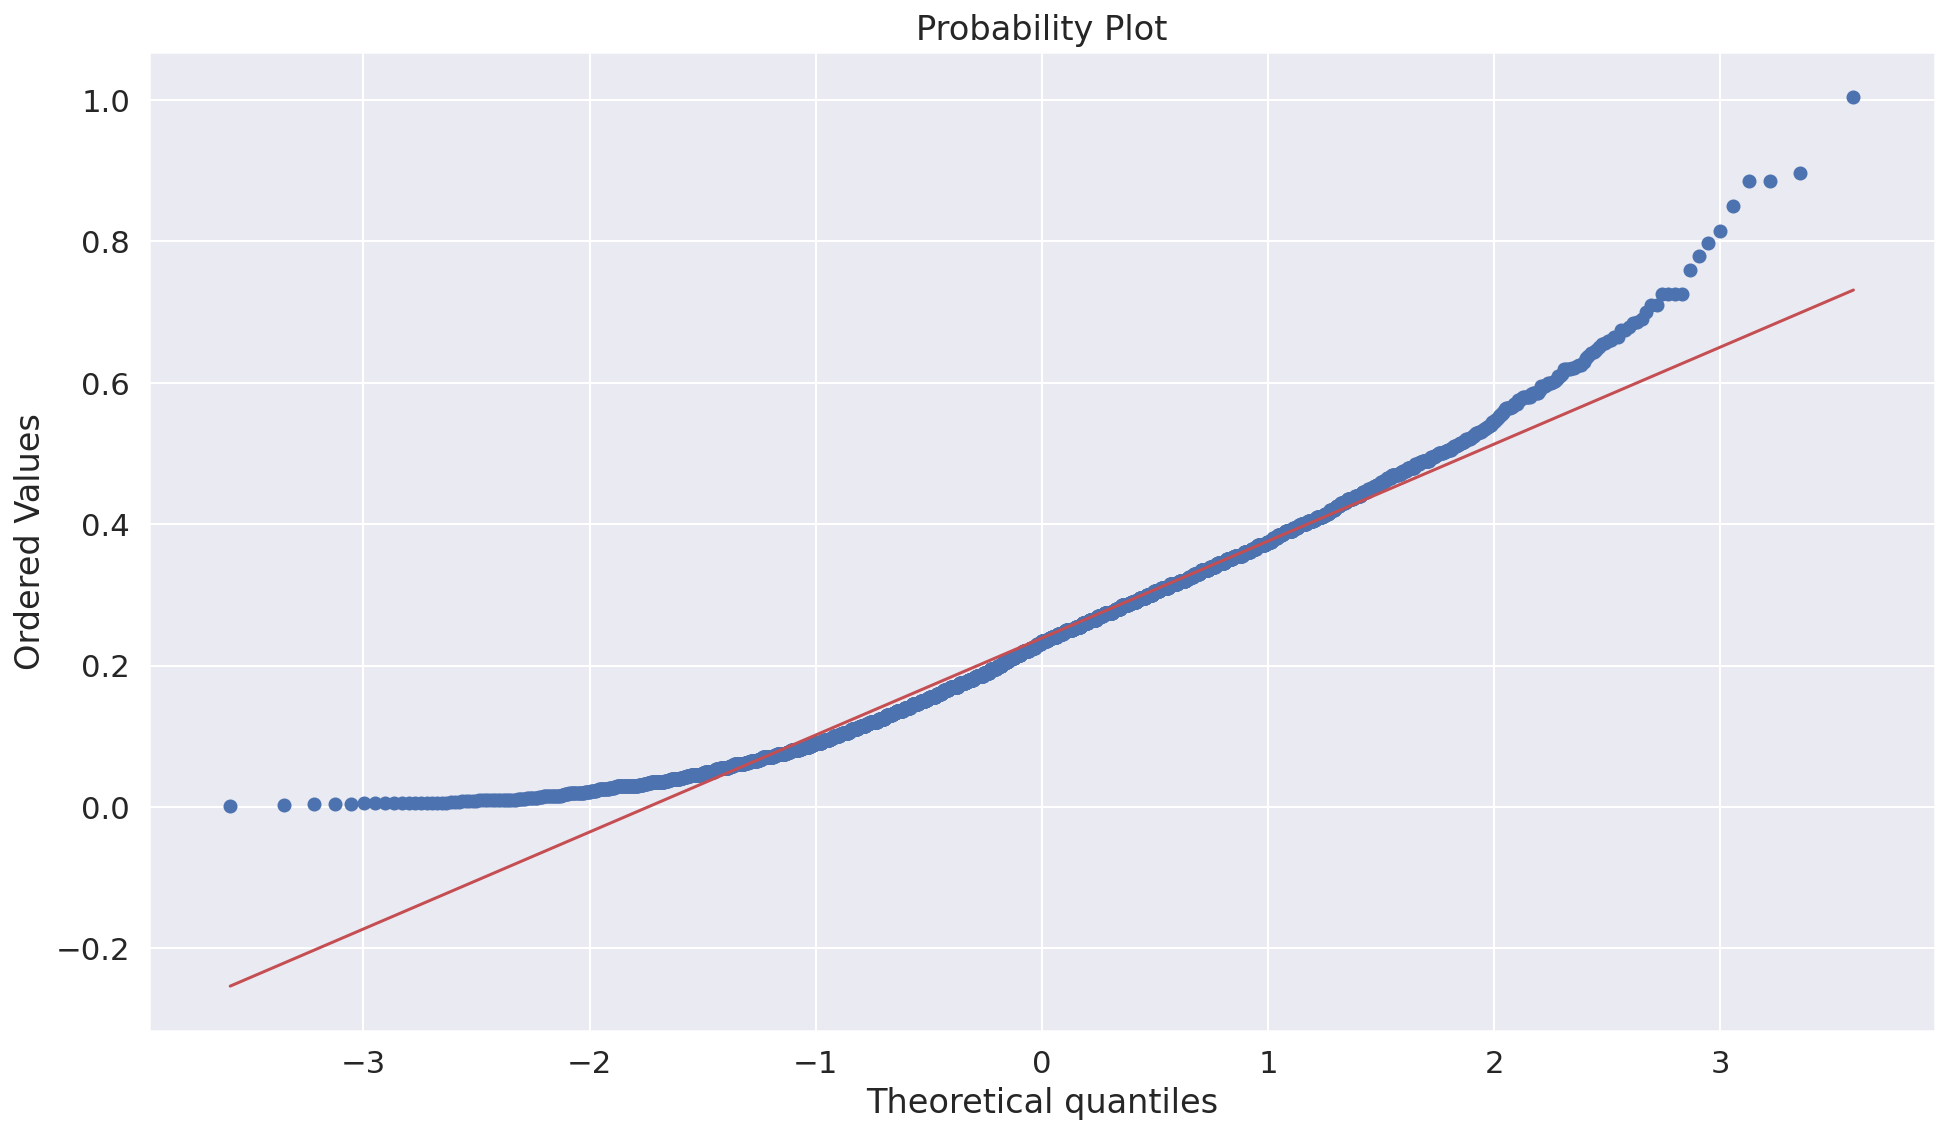

In [19]:
plt.figure(figsize = (16, 9))
sps.probplot(sample, plot=plt, dist = sps.norm)
plt.show()

In [20]:
a, sigma = sample.mean(), sample.var()
print(a, sigma)

0.23883085946851806 0.01937274413507649


In [21]:
sps.kstest(sample, sps.norm(a, np.sqrt(sigma)).cdf)

KstestResult(statistic=0.047466738420462284, pvalue=1.2858298600088461e-08)

Гипотеза отвергается

Посмотрим на первый и последний члены вариационного ряда:

In [22]:
print(min(sample), max(sample))

0.0015 1.005


Картина уже просматривается пояснее: носитель расположен от нуля до единицы (ну почти, отнормитруем немного), имеется один пик -- явное подозрение на бета распределение. При этом, легко заметить, что в данном случае хорошо применяется обобщенный критерий хи-квадрат. Будем брать бины равномерно до 0.5 ширины приблизительно 0.1, остальное запихнем в последний бин.

In [23]:
scale = max(sample)

In [24]:
def calc_inserts_to_boxes(vec_boxes):
    insert_to_boxes = np.zeros(len(vec_boxes))
    for val in sample:
        for ind, box in enumerate(vec_boxes):
            if val >= box[0] and val < box[1]:
                insert_to_boxes[ind] += 1
                break
    return insert_to_boxes

In [25]:
vec_boxes = np.array([[0, 0.1], [0.1, 0.18], [0.18 ,0.3], [0.3, 0.4], [0.4, 0.5], [0.5, scale]])
insert_to_boxes = calc_inserts_to_boxes(vec_boxes)
print(insert_to_boxes)

[ 747.  816. 1272.  816.  360.  165.]


In [26]:
def calc_chi_likelihood_beta(sample):
    def func_to_minimize(x):
        res = 0
        for ind, box in enumerate(vec_boxes):
            res -= insert_to_boxes[ind] * np.log(sps.beta(x[0], x[1], scale = scale).cdf(box[1]) -
                                                 sps.beta(x[0], x[1], scale = scale).cdf(box[0])) 
        return res
    min_params = minimize(func_to_minimize, [2, 5], method='Nelder-Mead')
    return min_params.x

In [27]:
params = calc_chi_likelihood_beta(sample)
params

array([2.0120792 , 6.46671406])

Согласно теореме Фишера, статистика хи-квадрат при верности гипотезы сходится по распределению к $\chi(k - d - 1)$, где $k$ -- число бинов, $d$ -- размерность пространства параметров. В нашем случае $k=6, d = 2$, следовательно сходимость по распредлению происходит к $\chi(4)$ и критерий выглядит так $\widehat{\chi} > u_{1 - \alpha}$, где $u_{1 - \alpha}$ --  $1 - \alpha$ квантиль распределения $\chi(3)$. 

In [28]:
def calc_chi_square_beta(a, b, n):
    p0 = sps.beta(a, b, scale = scale).cdf(vec_boxes[:, 1]) - sps.beta(a, b, scale = scale).cdf(vec_boxes[:, 0])
    return np.sum(np.power(insert_to_boxes - n * p0, 2) / (n * p0))

In [29]:
res = np.round(calc_chi_square_beta(params[0], params[1], len(sample)), 3)

In [30]:
crit_value = np.round(sps.chi(3).ppf(0.95), 3)
print("Значение статистики хи-квадрат равно ",res, f", критическое значение на уровне {al} равно", crit_value)

Значение статистики хи-квадрат равно  65.803 , критическое значение на уровне 0.05 равно 2.795


Гипотезу нужно отвергнуть. Но что делать дальше? Попробуем подкорректировать наше бета-распределение. Заметим, что основная проблема заключается в том, что на отрезке $[0,0.3]$ расположено слишком много данных. Значит, попробуем вначало добавить немного равномерного распределения. То есть, преполагаем что распределение имеет вид $e \cdot \beta(a, b) + (1 - e) \cdot U(0, \gamma)$. Чтобы оптимизатору было легче искать затем минимум, положим $e = 0.6$.

In [31]:
vec_boxes = np.array([[0, 0.1], [0.1, 0.18], [0.18 ,0.3], [0.3, 0.4], [0.4, 0.5], [0.5, scale]])
insert_to_boxes = calc_inserts_to_boxes(vec_boxes)
print(insert_to_boxes)

[ 747.  816. 1272.  816.  360.  165.]


In [32]:
def calc_chi_likelihood_beta(sample):
    def func_to_minimize(x):
        res = 0
        for ind, box in enumerate(vec_boxes):
            res -= insert_to_boxes[ind] * np.log(0.6 * (sps.beta(x[0], x[1], scale = scale).cdf(box[1]) -
                                                 sps.beta(x[0], x[1], scale = scale).cdf(box[0])) + 
                                                0.4 *  (sps.uniform(loc = 0 , scale = x[2]).cdf(box[1])
                                                                - sps.uniform(loc = 0 , scale = x[2]).cdf(box[0]))) 
        return res
    min_params = minimize(func_to_minimize, [2, 5, 0.5], method='Nelder-Mead')
    return min_params.x

In [33]:
params = calc_chi_likelihood_beta(sample)
params

array([2.07276596, 6.0844389 , 0.42780978])

In [34]:
def calc_chi_square_beta_uniform(a, b, gamma, n):
    p0 = 0.6 * (sps.beta(a, b, scale = scale).cdf(vec_boxes[:, 1]) - sps.beta(a, b, scale = scale).cdf(vec_boxes[:, 0]))  + 0.4 * (sps.uniform(loc = 0 , scale = gamma).cdf(vec_boxes[:, 1]) - sps.uniform(loc = 0 , scale = gamma).cdf(vec_boxes[:, 0]))
    return np.sum(np.power(insert_to_boxes - n * p0, 2) / (n * p0))

In [35]:
res = np.round(calc_chi_square_beta_uniform(params[0], params[1], params[2], len(sample)), 3)

In [36]:
crit_value = np.round(sps.chi(3).ppf(0.95), 3)
print("Значение статистики хи-квадрат равно ",res, f", критическое значение на уровне {al} равно", crit_value)

Значение статистики хи-квадрат равно  2.661 , критическое значение на уровне 0.05 равно 2.795


Таким образом, гипотеза о том, что данные имеют распредление $0.6 \cdot \beta(2, 6.42, scale = 1.005) + 0.4 \cdot U(0, 0.428)$ не отвергается.

### Задача 4

Сгенерируем тысячу выборок и для каждой посчитаем статистику Андресона-Дарлинга, затем с помощью моделирования (то есть эмпиричекси) найдем критические значения. 

In [104]:
num_samples = 1000
alphas = [0.01, 0.05, 0.1]
n_s = [25, 100, 500, 2000]

In [105]:
samples = sps.norm().rvs(size = (num_samples, n_s[-1]))

In [106]:
print(samples.shape)

(1000, 2000)


In [107]:
def calc_stats_vals(samples, n_s):
    stats_vals = []

    for n in n_s:
        batch = []
        for sample in samples:
            res = sps.anderson(sample[:n], 'norm')
            batch.append(res.statistic)
        stats_vals.append(batch)
    return stats_vals


In [108]:
stats_vals = calc_stats_vals(samples, n_s)

In [109]:
quantiles = []
for ind, n in enumerate(n_s):
    quants_for_n = []
    sort_vals = sorted(stats_vals[ind])
    for alpha in alphas:
        quant = sort_vals[int((1 - alpha) * len(sort_vals))]
        print(f"При n={n} критическим значением статистики Андерсона-Дарлинга при a={alpha} является {quant}")
        quants_for_n.append(quant)
    quantiles.append(quants_for_n)

При n=25 критическим значением статистики Андерсона-Дарлинга при a=0.01 является 0.9196212639117967
При n=25 критическим значением статистики Андерсона-Дарлинга при a=0.05 является 0.6939979276379624
При n=25 критическим значением статистики Андерсона-Дарлинга при a=0.1 является 0.5886387349132534
При n=100 критическим значением статистики Андерсона-Дарлинга при a=0.01 является 0.9002213570377364
При n=100 критическим значением статистики Андерсона-Дарлинга при a=0.05 является 0.7092511530045726
При n=100 критическим значением статистики Андерсона-Дарлинга при a=0.1 является 0.6122171627232689
При n=500 критическим значением статистики Андерсона-Дарлинга при a=0.01 является 1.0118978314829405
При n=500 критическим значением статистики Андерсона-Дарлинга при a=0.05 является 0.7367554822951661
При n=500 критическим значением статистики Андерсона-Дарлинга при a=0.1 является 0.6005404553367839
При n=2000 критическим значением статистики Андерсона-Дарлинга при a=0.01 является 0.934638755056

Посчитаем эмперический уровень значимости, или по другому ошибку первого рода:

In [43]:
new_samples = sps.norm.rvs(size = (num_samples, n_s[-1]))

In [44]:
new_stats_vals = calc_stats_vals(new_samples, n_s)

In [45]:
significance_levels = []
for ind, n in enumerate(n_s):
    batch = []
    for ind2, alpha in enumerate(alphas):
        higher = float(np.count_nonzero(new_stats_vals[ind] > quantiles[ind][ind2])) / num_samples
        print(f"При n={n} и a={alpha} эмперический уровень значимости равен {higher}")
        batch.append(higher)
    significance_levels.append(batch)

При n=25 и a=0.01 эмперический уровень значимости равен 0.005
При n=25 и a=0.05 эмперический уровень значимости равен 0.031
При n=25 и a=0.1 эмперический уровень значимости равен 0.072
При n=100 и a=0.01 эмперический уровень значимости равен 0.006
При n=100 и a=0.05 эмперический уровень значимости равен 0.047
При n=100 и a=0.1 эмперический уровень значимости равен 0.113
При n=500 и a=0.01 эмперический уровень значимости равен 0.017
При n=500 и a=0.05 эмперический уровень значимости равен 0.049
При n=500 и a=0.1 эмперический уровень значимости равен 0.098
При n=2000 и a=0.01 эмперический уровень значимости равен 0.011
При n=2000 и a=0.05 эмперический уровень значимости равен 0.083
При n=2000 и a=0.1 эмперический уровень значимости равен 0.137


Теперь сравним мощности критериев Колмогорова и Андерсона-Дарлинга при $H_0 = X \sim N(0, 1)$ проnтив альтернативы $H_1: X \sim T(10)$:

In [46]:
df = 10
t_samples = sps.t.rvs(df = df, size = (num_samples, n))

In [47]:
def get_cardinalities_Kolmogorov(samples, n_s, alphas, true_distr):
    cardinalities = np.zeros((len(n_s), len(alphas)))
    for sample in samples:
        for ind, n in enumerate(n_s):
            k_test = sps.kstest(sample[:n], true_distr.cdf)
            for ind2, alpha in enumerate(alphas):
                if k_test.pvalue < alpha:
                    cardinalities[ind][ind2] += 1
    cardinalities = cardinalities / float(samples.shape[0])
    return cardinalities

In [48]:
def get_cardinalities_Anderson(samples, n_s, alphas, quants):
    cardinalities = np.zeros((len(n_s), len(alphas)))
    for sample in samples:
        for ind, n in enumerate(n_s):
            anderson_test = sps.anderson(sample[:n], 'norm')
            for ind2, alpha in enumerate(alphas):
                if anderson_test.statistic > quants[ind][ind2]:
                    cardinalities[ind][ind2] += 1
    cardinalities = cardinalities / float(samples.shape[0])
    return cardinalities

In [49]:
Kolmogorov_cardinalities = get_cardinalities_Kolmogorov(t_samples, n_s, alphas, sps.norm)
Anderson_cardinalities = get_cardinalities_Anderson(t_samples, n_s, alphas, quantiles)

In [50]:
for ind, n in enumerate(n_s):
    for ind2, alpha in enumerate(alphas):
        K_c, A_c = Kolmogorov_cardinalities[ind][ind2], Anderson_cardinalities[ind][ind2]
        print(f"При n={n} и a={alpha} мощность критерия Колмогорова составляет {K_c}, критерия Андерсона-Дарлинга -- {A_c}")

При n=25 и a=0.01 мощность критерия Колмогорова составляет 0.008, критерия Андерсона-Дарлинга -- 0.026
При n=25 и a=0.05 мощность критерия Колмогорова составляет 0.045, критерия Андерсона-Дарлинга -- 0.091
При n=25 и a=0.1 мощность критерия Колмогорова составляет 0.106, критерия Андерсона-Дарлинга -- 0.133
При n=100 и a=0.01 мощность критерия Колмогорова составляет 0.012, критерия Андерсона-Дарлинга -- 0.068
При n=100 и a=0.05 мощность критерия Колмогорова составляет 0.05, критерия Андерсона-Дарлинга -- 0.163
При n=100 и a=0.1 мощность критерия Колмогорова составляет 0.101, критерия Андерсона-Дарлинга -- 0.255
При n=500 и a=0.01 мощность критерия Колмогорова составляет 0.018, критерия Андерсона-Дарлинга -- 0.314
При n=500 и a=0.05 мощность критерия Колмогорова составляет 0.056, критерия Андерсона-Дарлинга -- 0.472
При n=500 и a=0.1 мощность критерия Колмогорова составляет 0.124, критерия Андерсона-Дарлинга -- 0.599
При n=2000 и a=0.01 мощность критерия Колмогорова составляет 0.042, кри

**Вывод:** Можно заметить, что при различных $n$ критические значения статистики Андерсона-Дарлинга совпадают. Также, в очередной раз было показано, что способ моделирования достаточно эффективен (эмперический уровень значимости близок к фактическому).

Также было выяснено,что критерий Андерсона-Дарлинга значительно мощнее критерия Колмогорова-Смирнова для альтернативы $H_1: X \sim T(10)$. Теоретически это также имеет объяснение  -- критерий Колмогорова-Смирнова не реагирует на выбросы, а именно это отличительная черта распределения Стьюдента от нормального.

### Задача 5

Заметим, что в данной задаче нас просят взять выборку $X$ из смещенного экспоненциального распределения, то есть  X_i = Y_i + a, где $Y_i \sim exp(\lambda)$. Из этого следуют следующие свойства:

$$
EX_i = \frac{1}{\lambda} + a
$$
$$
D(X_i) = \frac{1}{\lambda^2}
$$
Для построения асимптотического доверительного интервала будем пользоваться стандартными приемами, а именно ЦПТ. 

Найдем оценку по методу моментов и покажем, что она будет состоятельной. В качестве пробный функций возьмем стандартные $g_1(x) = x$ и  $g_2(x) = x^2$. Тогда, имеем следующую систему:


$$
\begin{cases}
\widehat{a} + \frac{1}{\widehat{\lambda}} = \overline{X}\\
 \frac{1}{\widehat{\lambda}^2} + \Big(\widehat{a} + \frac{1}{\widehat{\lambda}}\Big)^2 = \overline{X^2}\\ 
\end{cases}
$$

Отсюда, имеем 

$$
\begin{cases}
\widehat{a} = \overline{X} - \sqrt{\overline{X^2} - \overline{X}}\\
\frac{1}{\widehat{\lambda}} = \sqrt{\overline{X^2} - \overline{X}^2}\\ 
\end{cases}
$$

Эти оценки являются состоятельными (и даже сильно состоятельными) по УЗБЧ.

Теперь обратимся к ЦПТ. Имеем

$$
\sqrt{n}\Big(\overline{X} - \Big(a + \frac{1}{\lambda}\Big)\Big) \cdot \lambda \sim N(0, 1)
$$
Согласно Теореме о наследовании сходимостей, имеем
$$
\sqrt{n}\Big(\overline{X} - \Big(a + \frac{1}{\widehat{\lambda}}\Big)\Big) \cdot \widehat{\lambda} \sim N(0, 1)
$$

Отсюда, асимптотический доверительный интервал будет иметь вид 

$$
\Big(\overline{X} - \frac{z_{\frac{1 + \alpha}{2}}}{\sqrt{n} \cdot \widehat{\lambda}} - \frac{1}{\widehat{\lambda}}, \overline{X} - \frac{z_{\frac{1 - \alpha}{2}}}{\sqrt{n} \cdot \widehat{\lambda}} - \frac{1}{\widehat{\lambda}}\Big)
$$

In [51]:
al = 0.95
n = 1000
a, lam = 18, 40 - 18
sample = sps.expon(scale = 1.0 / lam).rvs(n) + a

In [52]:
def draw_confidence_interval(n, a, lower, upper, title, lim):
    plt.figure(figsize =  (16, 9))
    plt.hlines(a, xmin = 1, xmax = n + 1, color = 'red', label = fr'истинное значение $a$')
    plt.fill_between(np.arange(n)[4::5] + 1, lower[4::5], upper[4::5], alpha = 0.2)
    plt.legend()
    plt.xlabel('Мощность выборки')
    plt.ylim(lim)
    plt.ylabel('Значения')
    plt.title(title)
    plt.show()

In [53]:
def calc_asymptotic_int(sample):
    sums = np.cumsum(sample) / np.arange(1, len(sample) + 1)
    inv_lam = np.sqrt(np.cumsum(np.power(sample, 2)) / np.arange(1, len(sample) + 1) - np.power(sums, 2))
    est = sums - inv_lam
    quant_minus = sps.norm.ppf((1-al)/2)
    quant_plus = sps.norm.ppf((1+al)/2)
    low = est - (quant_plus * inv_lam) / np.sqrt(np.arange(1, len(sample) + 1))
    up = est - (quant_minus * inv_lam) / np.sqrt(np.arange(1, len(sample) + 1)) 
    return  low, up

In [54]:
def calc_bootstrap_stats(bootstrap):
    sums = np.cumsum(bootstrap, axis = 1) / np.arange(1, bootstrap.shape[1] + 1)
    inv_lam = np.sqrt(np.cumsum(np.power(bootstrap, 2), axis = 1) / np.arange(1, bootstrap.shape[1] + 1) - np.power(sums, 2))
    est = sums - inv_lam
    return est

In [55]:
def calc_central_int(sample):
    sums = np.cumsum(sample) / np.arange(1, len(sample) + 1)
    inv_lam = np.sqrt(np.cumsum(np.power(sample, 2)) / np.arange(1, len(sample) + 1) - np.power(sums, 2))
    est = sums - inv_lam
    bootstrap = np.random.choice(sample, size=(len(sample), len(sample)))
    low, up = np.array([]), np.array([])
    stats = calc_bootstrap_stats(bootstrap)
    for sz in range(stats.shape[1]):
        vals = sorted(stats[:, sz])
        low = np.append(low, vals[int(stats.shape[0] * (1 - al) / 2)])
        up = np.append(up, vals[int(stats.shape[0] * (1 + al) / 2)])
    return 2 * est - up, 2*est - low

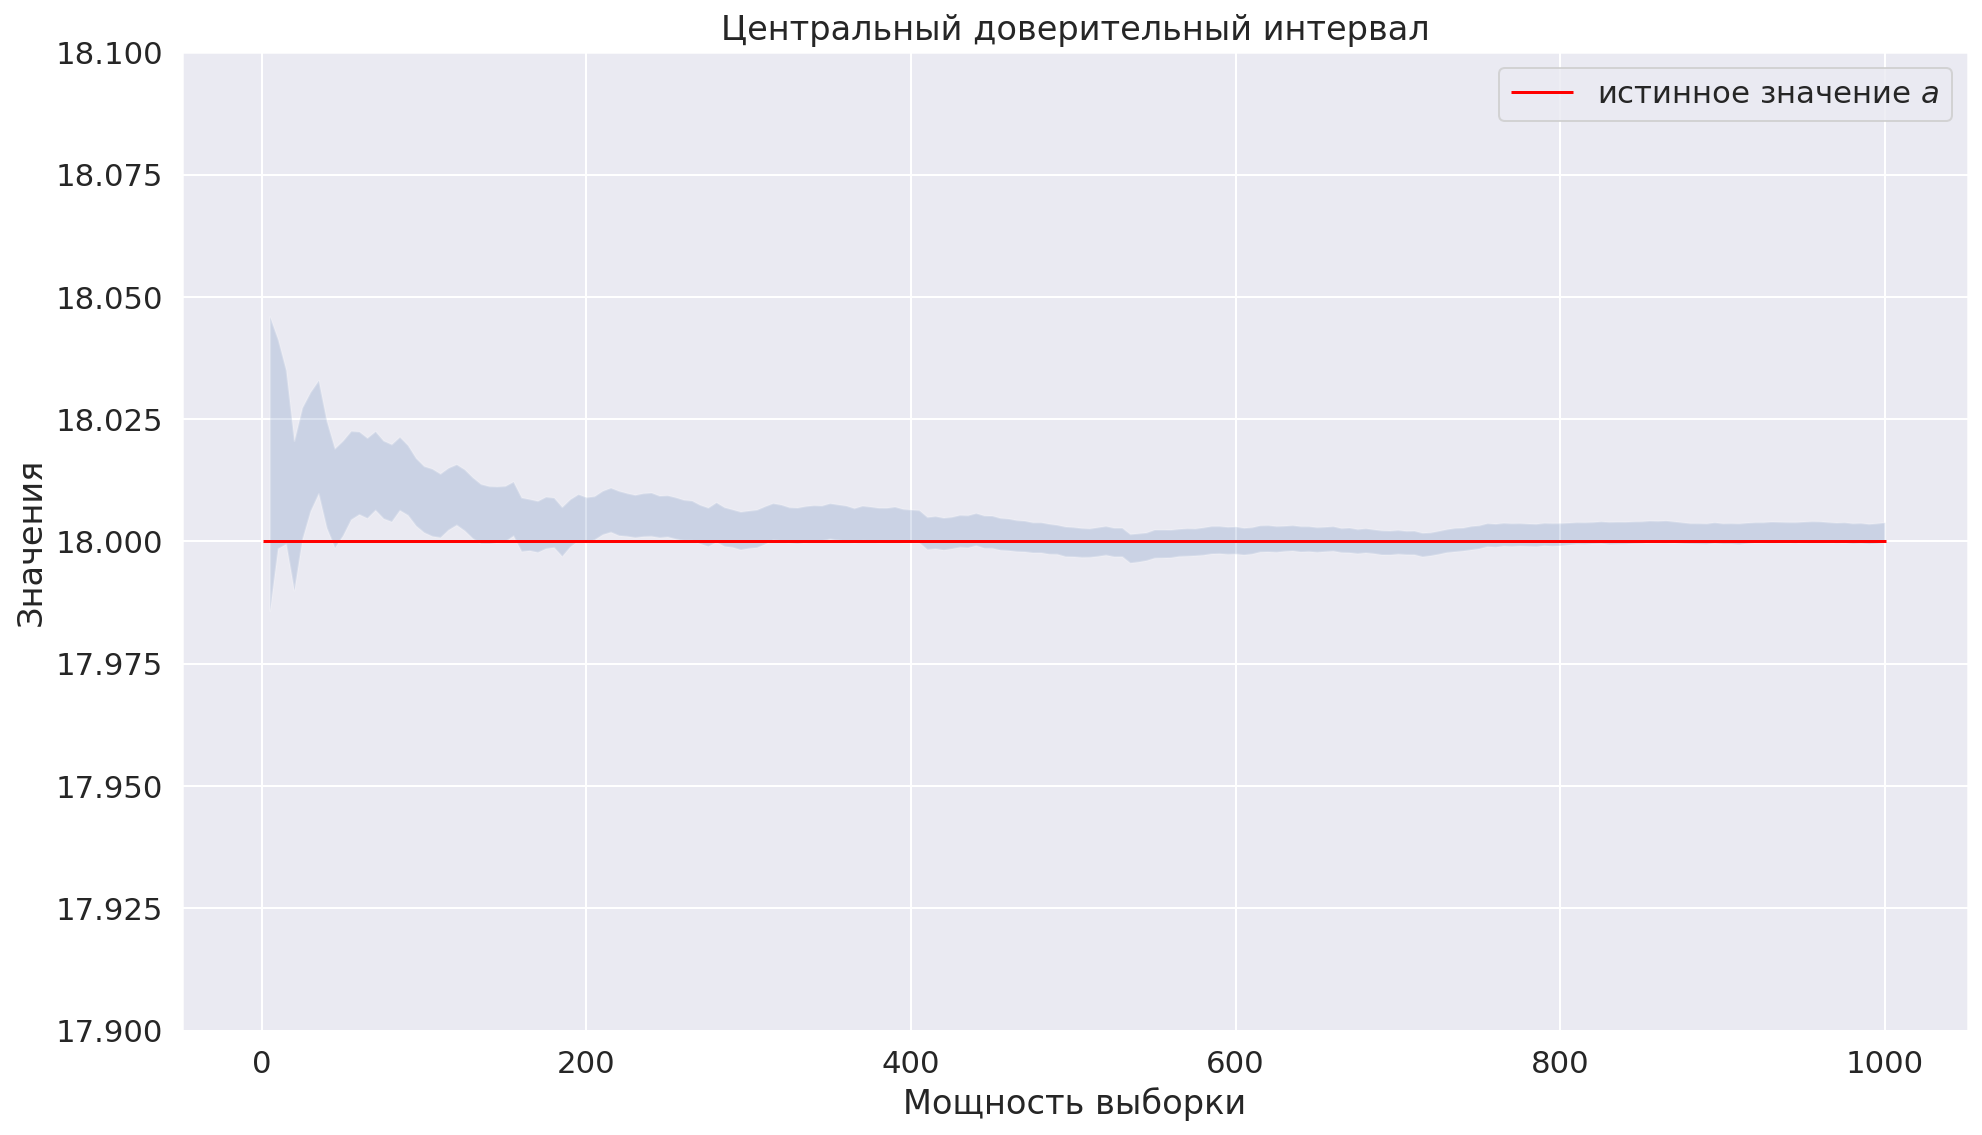

In [56]:
central_low, central_up = calc_central_int(sample)
draw_confidence_interval(n, a, central_low, central_up, "Центральный доверительный интервал", (17.9, 18.1))

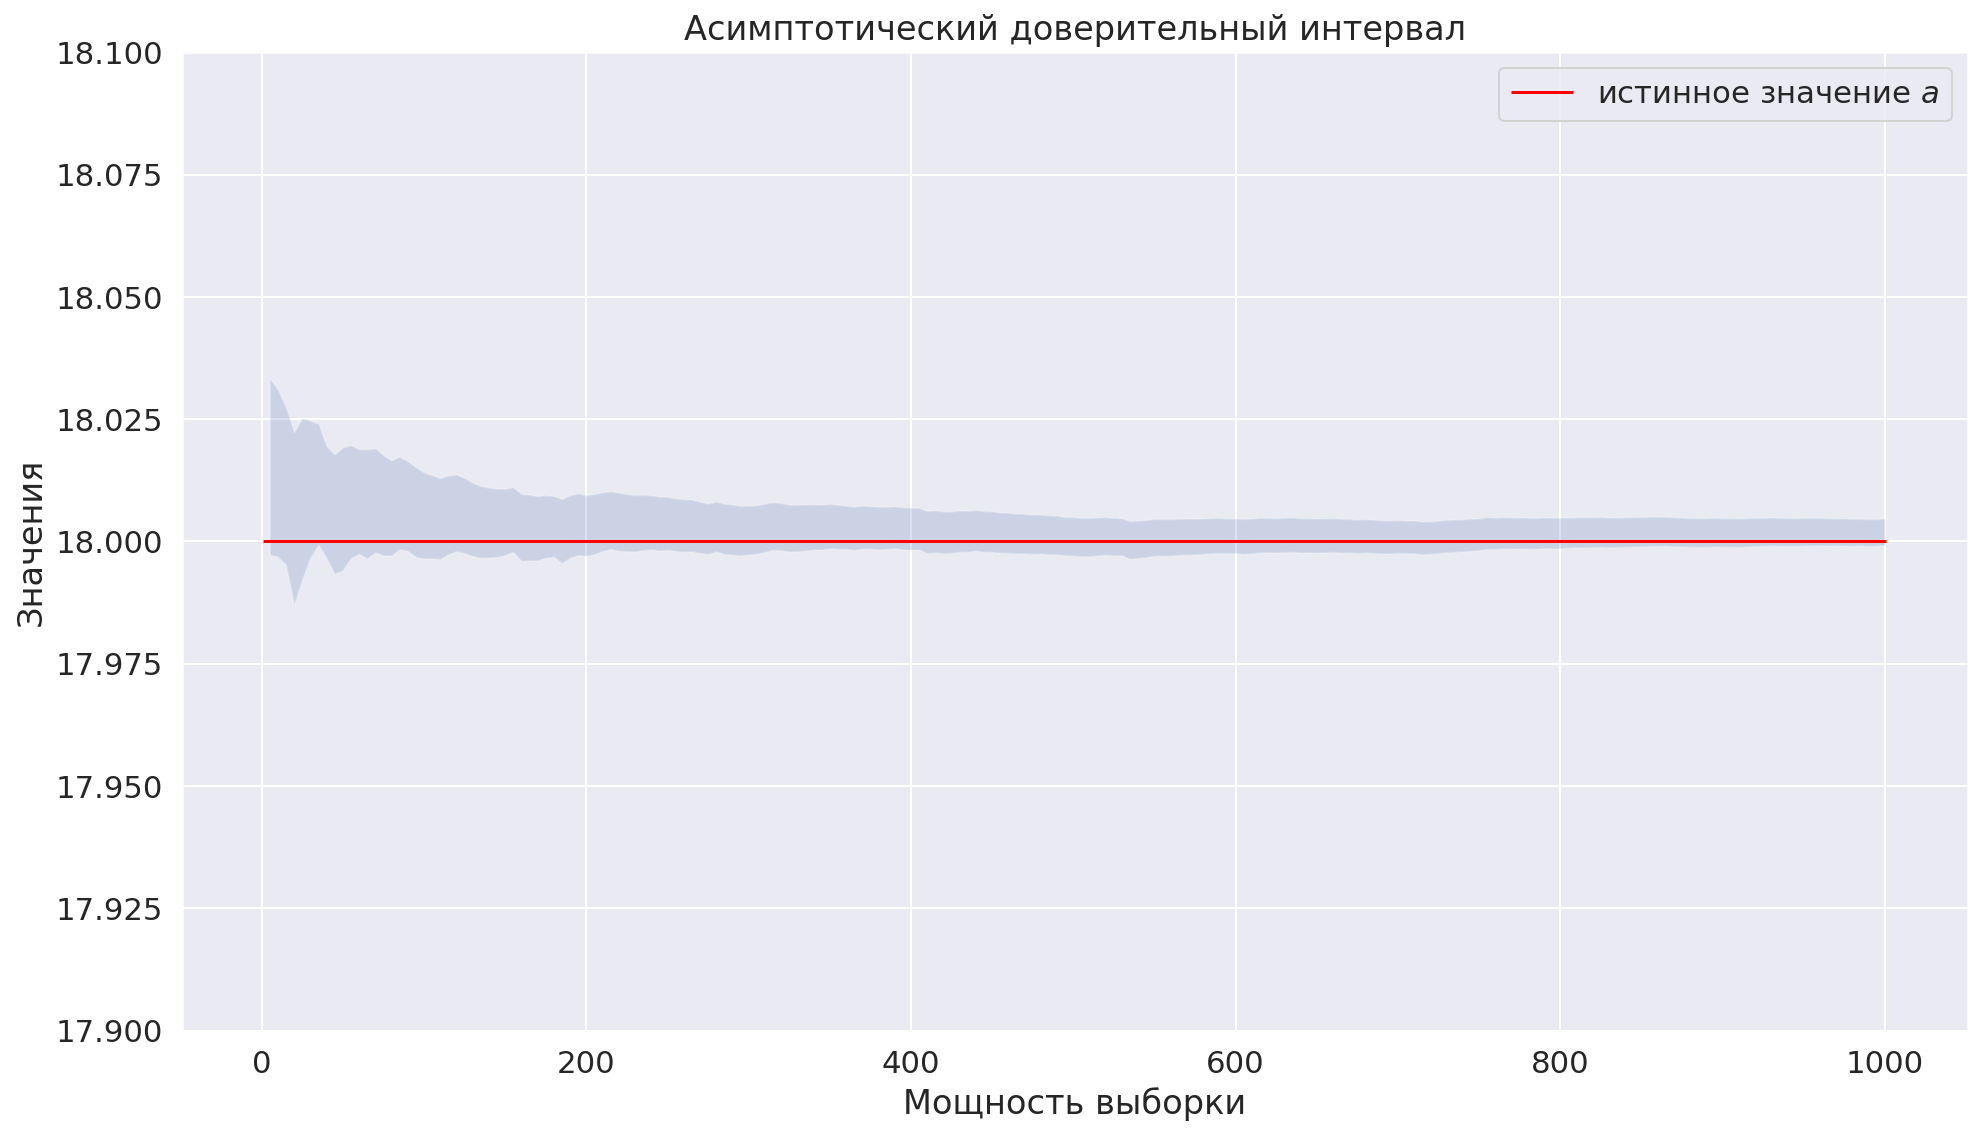

In [57]:
asymp_low, asymp_up = calc_asymptotic_int(sample)
draw_confidence_interval(n, a, asymp_low, asymp_up, "Асимптотический доверительный интервал", (17.9, 18.1))

In [58]:
num_samples = 100
samples = sps.expon(scale = 1.0 / lam).rvs((num_samples, n)) + a

asympt_low, asympt_up = [], []
central_low, central_up = [], []

for sample in samples:
    a_low, a_up = calc_asymptotic_int(sample)
    c_low, c_up = calc_central_int(sample)
    asympt_low.append(a_low)
    asympt_up.append( a_up)
    central_low.append(c_low)
    central_up.append(c_up)

In [59]:
asympt_low, asympt_up = np.array(asympt_low), np.array(asympt_up)
central_low, central_up = np.array(central_low), np.array(central_up)
probs_as = np.array([])
probs_cen = np.array([])

for sz in range(n):
        a_vals_low = asympt_low[:, sz]
        a_vals_up = asympt_up[:, sz]
        c_vals_low = central_low[:, sz]
        c_vals_up = central_up[:, sz]
        prob_a =  float(np.count_nonzero((a_vals_low <= a) & (a_vals_up >= a))) / num_samples
        prob_cen = float(np.count_nonzero((c_vals_low <= a) & (c_vals_up >= a))) / num_samples
        probs_as = np.append(probs_as, prob_a)
        probs_cen = np.append(probs_cen, prob_cen)

In [60]:
def draw_prob_plot(n, probs, title, lim):
    plt.figure(figsize =  (16, 9))
    plt.plot(np.arange(n) + 1, probs * 100, linewidth = 2.5)
    plt.xlabel('Мощность выборки')
    plt.ylim(lim)
    plt.title(title)
    plt.ylabel("вероятность, %")
    plt.show()

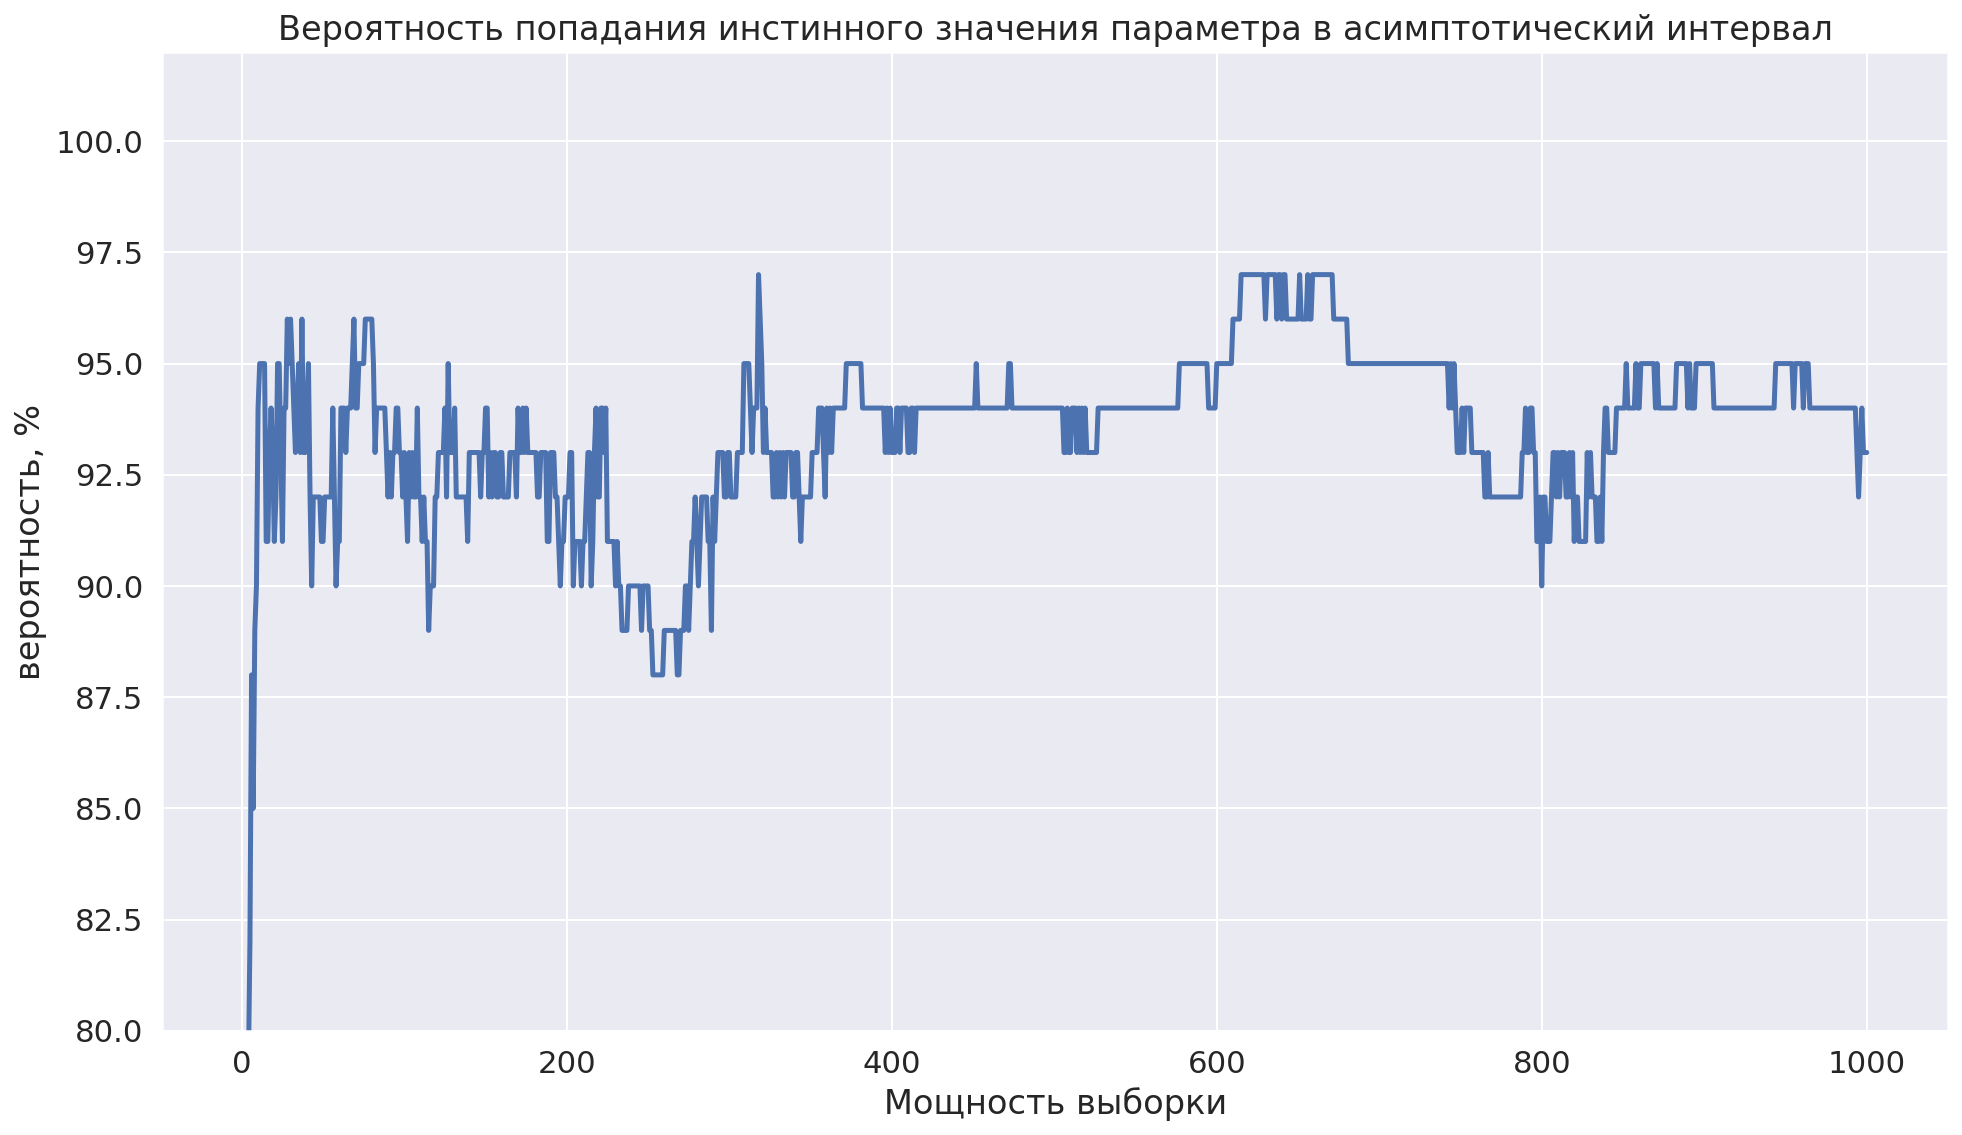

In [61]:
draw_prob_plot(n, probs_as, 'Вероятность попадания инстинного значения параметра в асимптотический интервал', (80, 102))

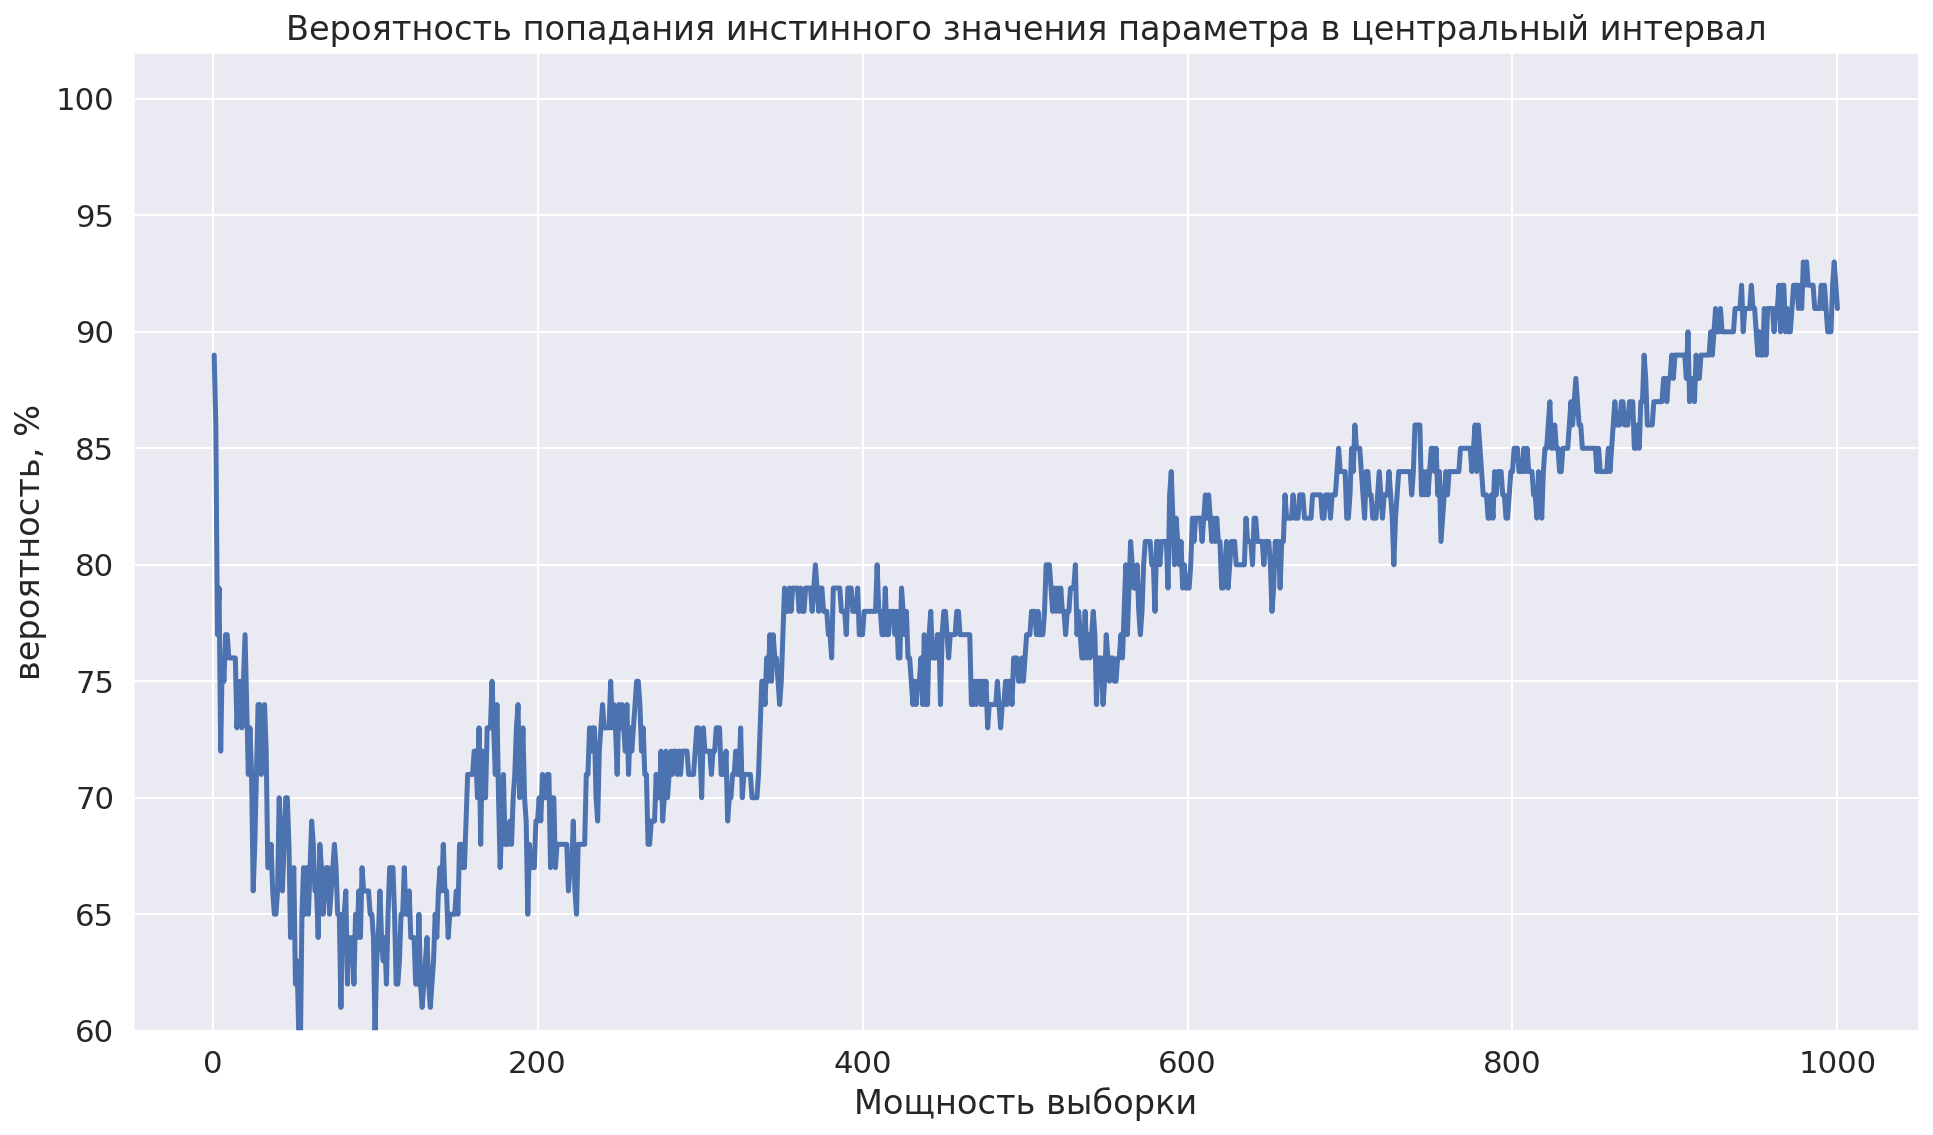

In [62]:
draw_prob_plot(n, probs_cen, 'Вероятность попадания инстинного значения параметра в центральный интервал', (60, 102))

**Вывод:** Исходя из вышеполученных графиков мы можем сделать вывод, что во-первых асимптотический доверительный интервал дейтвительно при $n \to \infty$ содержит истинное значение параметра, как и ожидалось согласно его определению. Цетральный интервал на малых размера выборки имеет немного меньшую, чем заданный уровень доверия, вероятность, однако при увеличении выборки вероятность также приближается к заданному уровню значимости. Это позволяет сделать вывод, что центральный интервал в некоторых случаях может заменять асимптотические и точные доверительные интервалы, что очень полезно, когда построить их сложно или невозможно.   